# MTHM503/J: Applied Linear Regression

# Predicting bicycle traffic by linear regression

*The analysis in this notebook is inspired by the [analysis in chapter 5.6 in the Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html#Example:-Predicting-Bicycle-Traffic).*

## Download data

On the ELE page you will find the file `FremontBridge.csv` which contains hourly bicycle traffic counts over Fremont Bridge in Seattle from October 2013 to August 2020. The file was downloaded from https://data.seattle.gov.

On the ELE page you will also find the file `SeattleWeather.csv` which contains daily weather observations from Seattle Airport. The data was downloaded from http://www.ncdc.noaa.gov/cdo-web/search?datasetid=GHCND (station id: USW00024233).

## Load packages and data

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

Read in the bicycle traffic counts and weather data with the function `read_csv` from the pandas package. The command will return a pandas DataFrame object. Both data sets have a date column which we will use as the index column of the DataFrame. This will help us merge the bicycle and weather data into a single DataFrame. Further we set `parse_dates` to `True` to tell the function to try to transform the date columns from a string to a proper date object.

In [2]:
bike = pd.read_csv('FremontBridge.csv', 
                   index_col='Date', parse_dates=False)
bike.index = pd.to_datetime(bike.index, format="%m/%d/%Y %I:%M:%S %p")
bike

,Fremont Bridge Total,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
Date,,,
2012-10-03 00:00:00,13.0,4.0,9.0
2012-10-03 01:00:00,10.0,4.0,6.0
2012-10-03 02:00:00,2.0,1.0,1.0
2012-10-03 03:00:00,5.0,2.0,3.0
2012-10-03 04:00:00,7.0,6.0,1.0
...,...,...,...
2020-08-31 19:00:00,190.0,79.0,111.0
2020-08-31 20:00:00,108.0,58.0,50.0
2020-08-31 21:00:00,33.0,11.0,22.0


In [5]:
weather = pd.read_csv('SeattleWeather.csv', index_col='DATE', parse_dates=False)
weather.index = pd.to_datetime(weather.index, format="%Y-%m-%d")
weather

,STATION,NAME,AWND,PRCP,TAVG,TMAX,TMIN
DATE,,,,,,,
2012-10-03,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",16.33,0.00,NaN,66,46
2012-10-04,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",14.54,0.00,NaN,66,47
2012-10-05,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",12.75,0.00,NaN,71,48
2012-10-06,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",11.41,0.00,NaN,75,46
2012-10-07,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",2.91,0.00,NaN,75,46
...,...,...,...,...,...,...,...
2020-08-27,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",5.82,0.00,67.0,81,55
2020-08-28,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",7.38,0.00,68.0,78,58
2020-08-29,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",5.59,0.00,66.0,70,55


## Data pre-processing

The bicycle traffic data has hourly counts. We will only be interested in daily counts, so we have to aggregate the counts to daily data. We first create a new column `date_day` where we format the index from hourly to format YYYY-MM-DD using `strftime`. Then we use the groupby-agg approach to sum up the hourly counts to daily counts. We finally rename the column and the index variable to something more descriptive.

In [6]:
bike['date_day'] = bike.index.strftime('%Y-%m-%d')
bike_daily = bike.groupby('date_day')['Fremont Bridge Total'].agg([np.sum])
bike_daily.rename(columns={'sum':'count'}, inplace=True)
bike_daily.index.name = 'date'
bike_daily.index = pd.to_datetime(bike_daily.index)
bike_daily

,count
date,
2012-10-03,7042.0
2012-10-04,6950.0
2012-10-05,6296.0
2012-10-06,4012.0
2012-10-07,4284.0
...,...
2020-08-27,3031.0
2020-08-28,2949.0
2020-08-29,2784.0


The `weather` data has a number of columns containing weather information for Seattle airport, including minimum temperature, maximum temperature, and precipitation amount.

In [7]:
weather

,STATION,NAME,AWND,PRCP,TAVG,TMAX,TMIN
DATE,,,,,,,
2012-10-03,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",16.33,0.00,NaN,66,46
2012-10-04,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",14.54,0.00,NaN,66,47
2012-10-05,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",12.75,0.00,NaN,71,48
2012-10-06,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",11.41,0.00,NaN,75,46
2012-10-07,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",2.91,0.00,NaN,75,46
...,...,...,...,...,...,...,...
2020-08-27,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",5.82,0.00,67.0,81,55
2020-08-28,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",7.38,0.00,68.0,78,58
2020-08-29,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",5.59,0.00,66.0,70,55


To make the weather data useable as features for our analysis we make a couple of changes:

- We rename the index column from `DATE` to `date` to make it consistent with the `bike_daily` DataFrame
- The average daily temperature has many missing values, but minimum and maximum temperature columns appear to be complete. So we create a new column `temperature` which is the midpoint between minimum and maximum temperature, as a proxy of the average temperature for that day.
- We convert temperature from Fahrenheit to Celsius
- We convert precipitation amounts from inches to mm
- We only keep the date, precipitation, and temperature column

In [8]:
weather.index.name = 'date'
weather['temperature'] = weather['TMIN'] + 0.5 * (weather['TMAX'] - weather['TMIN'])
weather['temperature'] = (weather['temperature'] - 32) * 5/9
weather['precip'] = weather['PRCP'] * 25.4
weather = weather.loc[:, ['temperature', 'precip']]

weather

,temperature,precip
date,,
2012-10-03,13.333333,0.000
2012-10-04,13.611111,0.000
2012-10-05,15.277778,0.000
2012-10-06,15.833333,0.000
2012-10-07,15.833333,0.000
...,...,...
2020-08-27,20.000000,0.000
2020-08-28,20.000000,0.000
2020-08-29,16.944444,0.000


Now we can merge the bike and weather data into a single data frame. Since both have an index column called `date` we are guaranteed that the data are correctly aligned by date.

In [9]:
bike_weather = pd.concat([bike_daily, weather], axis=1)
bike_weather

,count,temperature,precip
date,,,
2012-10-03,7042.0,13.333333,0.000
2012-10-04,6950.0,13.611111,0.000
2012-10-05,6296.0,15.277778,0.000
2012-10-06,4012.0,15.833333,0.000
2012-10-07,4284.0,15.833333,0.000
...,...,...,...
2020-08-27,3031.0,20.000000,0.000
2020-08-28,2949.0,20.000000,0.000
2020-08-29,2784.0,16.944444,0.000


It's always good to check that there are no rows with missing data:

In [10]:
bike_weather.isnull().agg([np.sum])

,count,temperature,precip
sum,0,0,0


## Some exploratory data analysis

### Time series plots

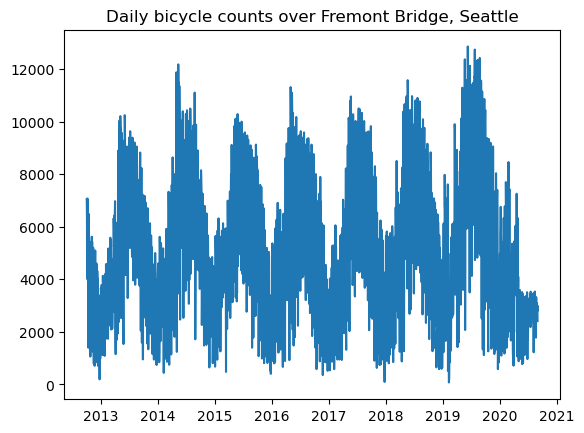

In [11]:
plt.plot(bike_weather['count'], '-')
plt.title('Daily bicycle counts over Fremont Bridge, Seattle')
plt.show()

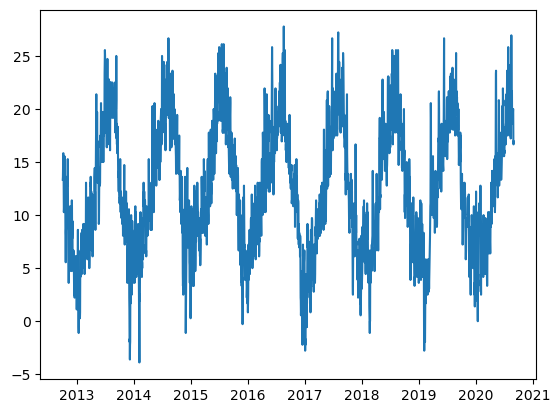

In [12]:
plt.plot(bike_weather['temperature'], '-')
plt.show()

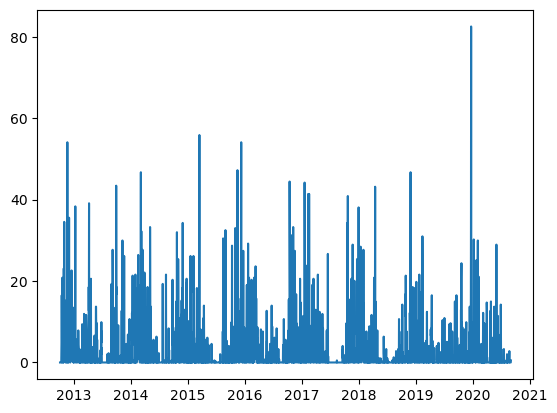

In [13]:
plt.plot(bike_weather['precip'], '-')
plt.show()

**Observations**

- There is a clear seasonal pattern in bicycle counts in Seattle, ranging from up to 12000 per day in summer to almost zero in winter.
- As expected, there is also a seasonal pattern in temperature and precipitation.
- There is also some indication of an upward trend in bicycle counts, that is a gradual increase over time, at least in the annual maximum.
- The year 2020 is clearly different from the other years, most likely due to the covid-19 lockdown and due to civil unrest in Seattle during this time.

**Possible research questions**

- How much of the 2012-2019 bicycle traffic can be explained by a simple sinusoidal pattern, without regard for weather effects?
- In addition to the sinusoidal pattern, can we detect an effect on bicycle counts due to
  - a constant linear increase over time
  - daily temperature values
  - daily precipitation values
- How much does the model prediction for 2020 differ from the actually observed bicycle counts? (This difference can allow us to analyse the effect of Seattle's covid-19 lockdown and civil unrest during this period.)

## Fitting a seasonal model

We start by assuming that the bicycle counts $y_1, \dots, y_n$ can be modelled as an annual sinusoidal oscillation around a constant mean level

$$y_t = \beta_0 + A\sin(\omega t + \phi) + \epsilon_t$$

The constant $A$ is the amplitude of the oscillation, the constant $\omega$ is the frequency, and $\phi$ is the phase shift. Since we assume an annual oscillation, we can set $\omega = 2\pi/365.25$. The parameters $A$ and $\phi$ are unknown and have to be estimated. 

In this form the model for $y$ cannot be fitted by simple linear regression, because one of the unknown parameters $\phi$ appears inside a nonlinear function ($\sin$).  But we can use the trigonometric equality $\sin(x + y) = \sin(x)\cos(y) + \cos(x)\sin(y)$ so we have $A\sin(\omega t + \phi) = A\sin(\omega t)\cos(\phi) + A\cos(\omega t)\sin(\phi)$. We can rewrite the seasonal model for $y_t$ as

$$y_t = \beta_0 + \beta_1 \sin[2\pi / (365.25) t] + \beta_2 \cos[2\pi / (365.25) t] + \epsilon_t$$

where the unknown parameters $\beta_1$ and $\beta_2$ are related to the amplitude $A$ and phase factor $\phi$. By defining the covariates 

$$x_{1,t} = \sin[2\pi/(365.25) t]$$

and

$$x_{2,t} = \cos[2\pi/(365.25) t]$$

we can write

$$y_t = \beta_0 + \beta_1 x_{1,t} + \beta_2 x_{2,t} + \epsilon_t$$

We want to only fit the model to data from "normal" times, that is to all data up the end of 2019.

In [14]:
bike_weather_normal = bike_weather[bike_weather.index.year <= 2019]

We start by defining the feature matrix $X$

In [23]:
n = bike_weather_normal.shape[0]
t = np.arange(n)
omega = 2 * np.pi / 365.25
X_seas = np.stack([np.sin(omega * t), np.cos(omega * t)], axis=1)

In [24]:
##we use the 365.25 to aproximate the leap year

In [25]:
X_seas

array([[0.        , 1.        ],
       [0.01720158, 0.99985204],
       [0.03439806, 0.99940821],
       ...,
       [0.9962103 , 0.08697723],
       [0.99755905, 0.06982798],
       [0.9986126 , 0.05265806]])

We also define the target vector $y$

In [26]:
y = bike_weather_normal['count']

In [27]:
lm = LinearRegression()

In [28]:
lm_seas = lm.fit(X_seas, y)

In [29]:
lm_seas.intercept_

5531.201955838146

In [30]:
lm_seas.coef_

array([-2377.53511058,   227.07393563])

Now we plot the count data and the fitted values of the seasonal model:

In [31]:
y_seas = pd.Series(data=lm_seas.predict(X_seas), index=y.index)

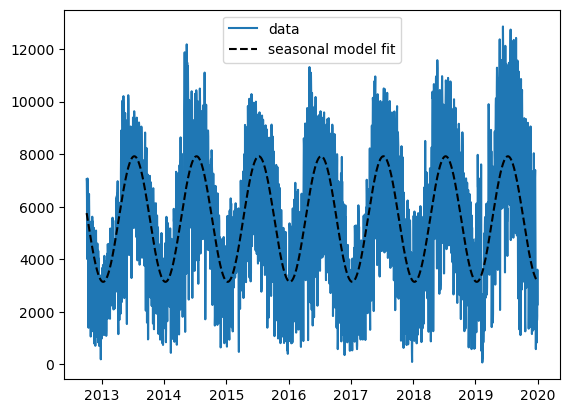

In [32]:
plt.plot(y, label='data')
plt.plot(y_seas, '--k', label='seasonal model fit')
plt.legend()
plt.show()

The fitted model produced a seasonally varying function that roughly matches the amplitude and phase of the count data.

To quantify how much of the variability of the data is explained by the seasonal model fit, we compare the variance of the data to the variance of the residuals of the seasonal fit. The smaller the variance of the residuals is compared to the total variance, the more explanatory power our model has.

In [22]:
total_var = np.var(y.values)
resid_var_seas = np.var(y.values - y_seas.values)

In [23]:
[total_var, resid_var_seas]

[7503780.202620763, 4668754.129734491]

The coefficient of determination $R^2$ is given by one minus the ratio of residual variance to total variance. If the residual variance equals total variance, the model does not explain anything and $R^2 = 0$. If the residual variance is 0, the model fits the data perfectly, and $R^2 = 1$. So $R^2$ measures model fit on a scale from zero to one.

In [24]:
R2_seas = 1 - resid_var_seas / total_var
R2_seas

0.3778130484014063

The seasonal model explains about 38% percent of the variance of the data.

## Including a linear trend

The next model we fit adds a linear function of time to the seasonal pattern. The mathematical form is as follows

$$y_t = \beta_0 + \beta_1 \sin(\omega t) + \beta_2 \cos(\omega t) + \beta_3 t + \epsilon_t$$

We can interpret the parameter $\beta_3$ as the additional number of cyclists per day.

In [25]:
X_seas_trnd = np.hstack([X_seas, np.arange(n).reshape(n, 1)])

In [26]:
lm_seas_trnd = lm.fit(X_seas_trnd, y)

We calculate the fitted values ...

In [27]:
y_seas_trnd = pd.Series(data=lm_seas_trnd.predict(X_seas_trnd),
                        index=y.index)

... and plot them together with the data and the seasonal-only fitted values:

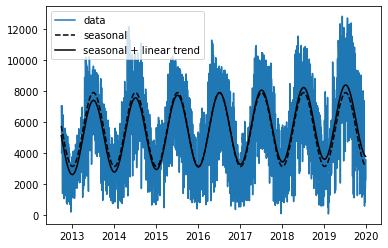

In [28]:
plt.plot(y, label='data')
plt.plot(y_seas, '--k', label='seasonal')
plt.plot(y_seas_trnd, '-k', label='seasonal + linear trend')
plt.legend()
plt.show()

The model picks up a slight upward trend, but is generally very similar to the seasonal-only model.

In [29]:
lm_seas_trnd.coef_

array([-2.35065523e+03,  2.01574116e+02,  4.52350809e-01])

The least squares estimate of $\beta_3$ is approximately $0.45$. This can be interpreted as an average increase of **about 45 additional cyclists every 100 days** over the study period.

The $R^2$ of the seasonal plus trend model is only very slightly bigger than the $R^2$ of the seasonal-only model

In [30]:
resid_var_seas_trnd = np.var(y_seas_trnd - y)
R2_seas_trnd = 1 - resid_var_seas_trnd / total_var
R2_seas_trnd

0.3936335421590138

## Effect of rainy days

To assess the effect of rainy days, let's add an indicator variable $I(precip_t \ge 1)$ to the feature matrix, that is zero on days where precipitation is less than 1mm, and one on days where precipitation is at least 1mm

$$y_t = \beta_0 + \beta_1 \sin(\omega t) + \beta_2 \cos(\omega t) + \beta_3 t + \beta_4 I(precip_t \ge 1) + \epsilon_t$$


In [31]:
wet = 1 * (bike_weather_normal['precip'] > 1)
X4 = np.hstack([X_seas_trnd, wet.values.reshape(n,1)])

In [32]:
lm_4 = lm.fit(X4, y)
y_4 = pd.Series(data=lm_4.predict(X4), index=y.index)
lm_4.coef_

array([-2.02878415e+03,  1.61224688e+02,  4.38303298e-01, -1.41223976e+03])

The effect of including a wetness indicator is quite dramatic, as indicated by the large coefficient of about -1400. The effect of rain is that, on average, about 1400 fewer people cycle on wet days than on dry days. Since winters in Seattle are wetter than summers, there is a strong correlation between the seasonal predictors and the wetness indicator. As a result, the seasonality coefficients $\beta_1$ and $\beta_2$ change by quite a bit after including the wetness indicator.

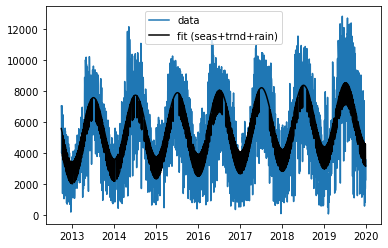

In [33]:
plt.plot(y, '-', label='data')
plt.plot(y_4, '-k', label='fit (seas+trnd+rain)')
plt.legend()
plt.show()

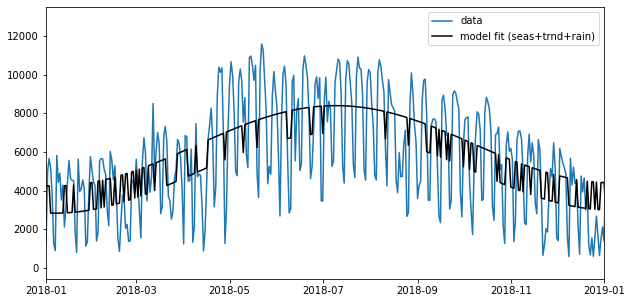

In [34]:
plt.figure(figsize=[10,5])
plt.plot(y, '-', label='data')
plt.plot(y_4, '-k', label='model fit (seas+trnd+rain)')
plt.xlim(pd.to_datetime(['2018', '2019']))
plt.legend()
plt.show()

In [35]:
resid_var_4 = np.var(y_4 - y)
R2_4 = 1 - resid_var_4 / total_var
R2_4

0.44680726391007786

## 2020 prediction vs reality

We now have a model for bicycle traffic behavior in Seattle, fitted to data from 2012 to 2019. We can use this model to predict bicycle traffic into the future, to 2020, 2021, 2022, etc, or also back into the past if we wanted. The underlying assumption in such a prediction would be that the training period 2012-2019 is representative of other periods. So the prediction we get from the model can be interpreted as a prediction under "business-as-usual" conditions. 

We now know that 2020 was not a business-as-usual year by any stretch of the imagination. The world was largely on lockdown due to the Covid-19 pandemic which surely had an effect on bicycle traffic. In addition, Seattle saw a couple of month of civil unrest and riots in the summer of 2020, which surely also affected commuter behavior.

To quantify the effect of the 2020 covid lockdown and social unrest on Seattle bicycle traffic, we use the model fitted to the pre-2020 data and compare its 2020 prediction to the actually observed 2020 data. The mismatch between prediction and observation will tell us how much bicycle traffic differed in 2020 compared to "normal" times.

To keep things simple, we only use the seasonal + linear trend model for the prediction. The pre-2020 model is used to express our expectation for 2020, and the discrepancy between expected and actual data in 2020 will be taken as an indicator for the effect of the unusual circumstances of 2020.

In [36]:
# refit model to seasonal and trend design matrix (pre-2020 data)
lm_seas_trnd = lm.fit(X_seas_trnd, y)

# construct design matrix that includes 2020 data
n_all = bike_weather.shape[0]
t_all = np.arange(n_all)
omega = 2 * np.pi / 365.25
X_all = np.stack([np.sin(omega * t_all), np.cos(omega * t_all), np.arange(n_all)], axis=1) # seasonal + trend

# predict for the entire period, using the model trained on pre-2020 data
y_all = pd.Series(data=lm_seas_trnd.predict(X_all), index=bike_weather.index)

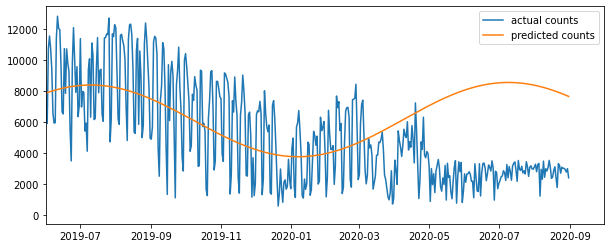

In [37]:
plt.figure(figsize=[10,4])
plt.plot(bike_weather['count'], '-', label='actual counts')
plt.plot(y_all, '-', label='predicted counts')
plt.xlim(pd.to_datetime(['2019-06','2020-10']))
plt.legend()
plt.show()


In [39]:
y_all

date
2012-10-03    5134.542127
2012-10-04    5094.529680
2012-10-05    5054.469558
2012-10-06    5014.373750
2012-10-07    4974.254254
                 ...     
2020-08-27    7797.276830
2020-08-28    7767.042122
2020-08-29    7736.355080
2020-08-30    7705.224919
2020-08-31    7673.660984
Length: 2890, dtype: float64

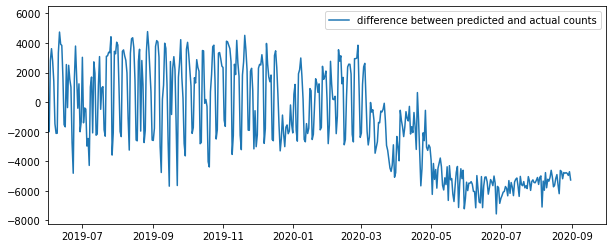

In [40]:
plt.figure(figsize=[10,4])
plt.plot(bike_weather['count'] - y_all, '-', label='difference between predicted and actual counts')
plt.xlim(pd.to_datetime(['2019-06','2020-10']))
plt.legend()
plt.show()


The difference between expected and actual bicycle traffic remains centered around 0 until about March, and starts going down significantly after that. The average difference after March 2020 goes down to around -6000, meaning that **about 6000 fewer people** crossed Fremont bridge by bike every day during that time.